In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.utils.data.sampler as sampler
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import random

In [3]:
def all_seed(seed=6666, env=None):
    if env is not None:
        env.seed(seed)
        env.action_space.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # CPU
    torch.manual_seed(seed)
    # GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
    # python全局
    os.environ['PYTHONHASHSEED'] = str(seed)
    # cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    print(f'Set env random_seed = {seed}')

all_seed(0)

Set env random_seed = 0


# dataPrepare

In [4]:
# 旋转 MNIST 数据生成 5 个任务
def _rotate_image(image, angle):
    if angle is None:
        return image
    image = transforms.functional.rotate(image, angle=angle)
    return image


def get_transform(angle=None):
    transform = transforms.Compose([
        transforms.ToTensor(),
       transforms.Lambda(lambda x: _rotate_image(x, angle)),
       Pad(28)
    ])
    return transform


class Pad(object):
    def __init__(self, size, fill=0, padding_mode='constant'):
        self.size = size
        self.fill = fill
        self.padding_mode = padding_mode

    def __call__(self, img):
        # 输入图片的长宽是一致的，如果输入图片的size比期望的size小时，对图片的四周进行扩充
        img_size = img.size()[1]
        assert ((self.size - img_size) % 2 == 0)
        padding = (self.size - img_size) // 2
        padding = (padding, padding, padding, padding)
        return F.pad(img, padding, self.padding_mode, self.fill)

    
class Data():
    def __init__(self, path, train=True, angle=None):
        transform = get_transform(angle)
        self.dataset = datasets.MNIST(root=os.path.join(path, "MNIST"), transform=transform, train=train, download=True)

In [5]:
class Args:
    task_number = 5
    epochs_per_task = 10
    lr = 1.0e-4
    batch_size = 128
    test_size=8192

args=Args()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 给每个task 生成旋转角度.
angle_list = [20 * x for x in range(args.task_number)]
# 准备5个Task: 不同旋转角度的 MNIST 数据集.
train_datasets = [Data('data', angle=angle_list[index]) for index in range(args.task_number)]
train_dataloaders = [DataLoader(data.dataset, batch_size=args.batch_size, shuffle=True) for data in train_datasets]

test_datasets = [Data('data', train=False, angle=angle_list[index]) for index in range(args.task_number)]
test_dataloaders = [DataLoader(data.dataset, batch_size=args.test_size, shuffle=True) for data in test_datasets]

100%|██████████| 9912422/9912422 [00:26<00:00, 369436.22it/s]


Extracting data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno -3] Temporary failure in name resolution>



100%|██████████| 28881/28881 [00:00<00:00, 61057.37it/s]


Extracting data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:07<00:00, 206490.57it/s]


Extracting data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14725.35it/s]

Extracting data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw



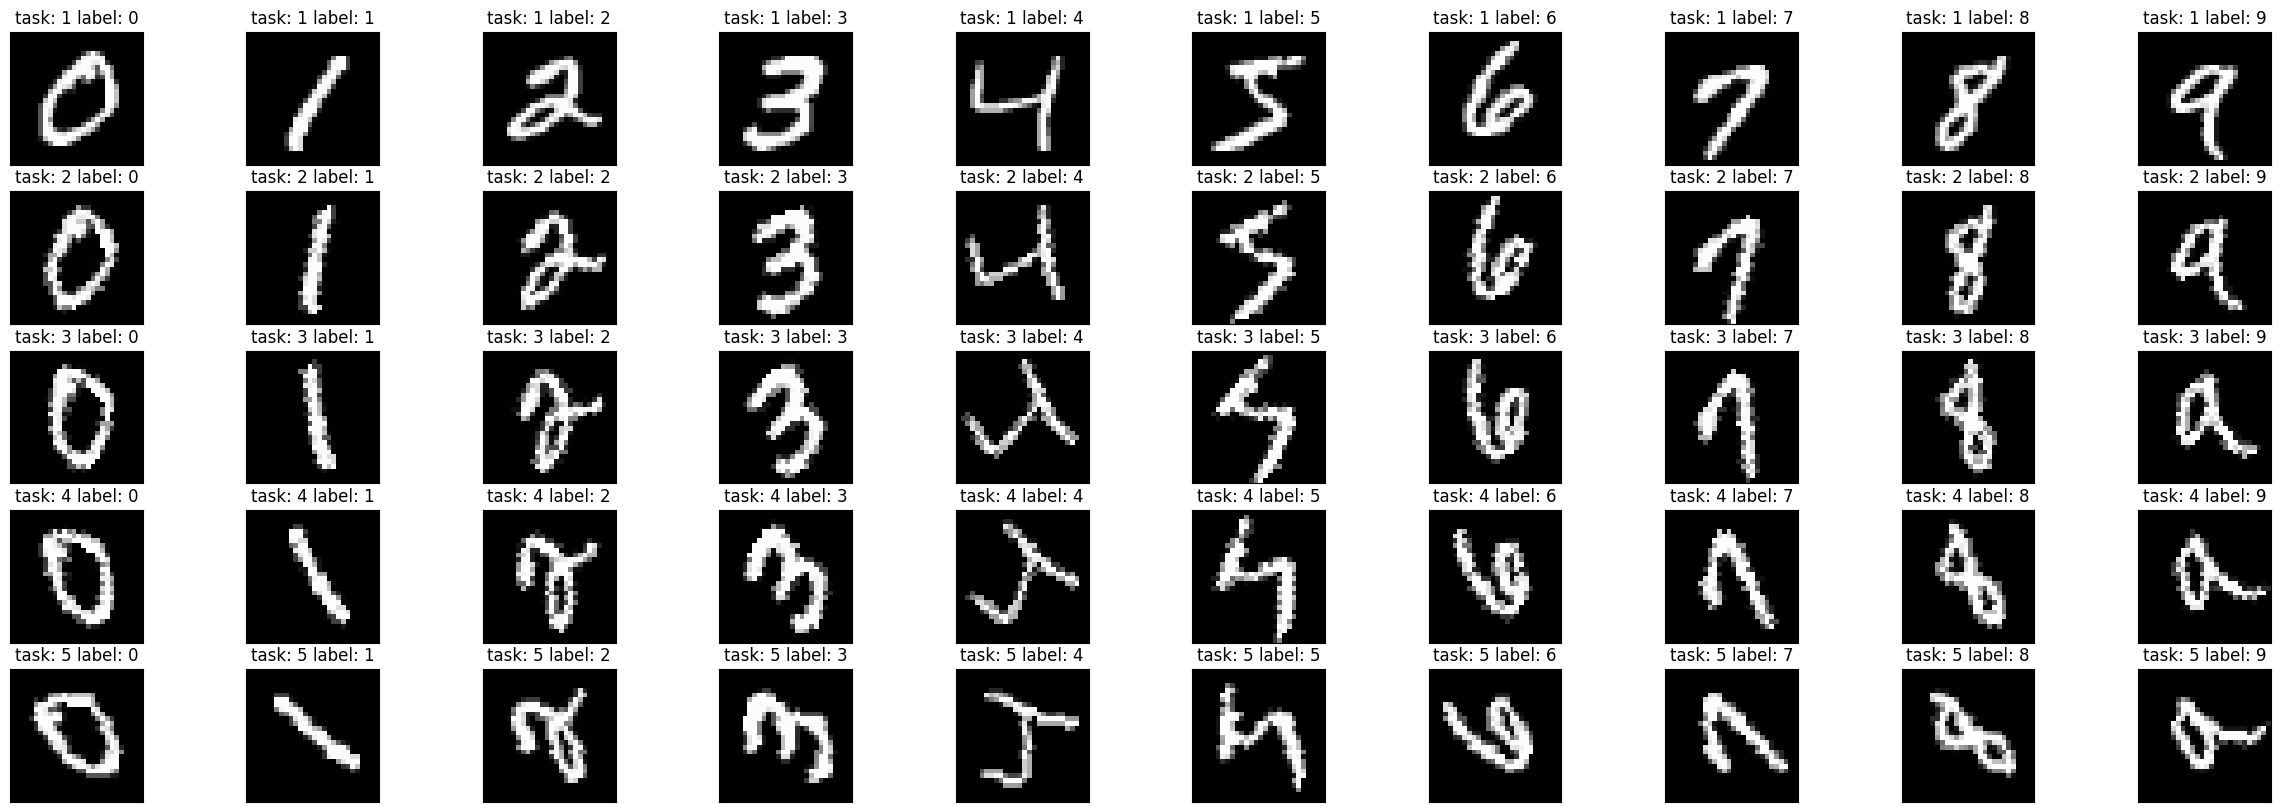

In [6]:
# 分别绘制5个任务中的0-9图像
sample = [Data('data', angle=angle_list[index]) for index in range(args.task_number)]

plt.figure(figsize=(30, 10))
for task in range(5):
    target_list = []
    cnt = 0
    while (len(target_list) < 10):
        img, target = sample[task].dataset[cnt]
        cnt += 1
        if target in target_list:
            continue
        else:
            target_list.append(target)
        plt.subplot(5, 10, (task)*10 + target + 1)
        curr_img = np.reshape(img, (28, 28))
        plt.matshow(curr_img, cmap=plt.get_cmap('gray'), fignum=False)
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        plt.title("task: " + str(task+1) + " " + "label: " + str(target), y=1)

# Base Model

In [7]:
class Model(nn.Module):
    """
    Model architecture 
    1*28*28 (input) → 1024 → 512 → 256 → 10
    """
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(1*28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 1*28*28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x


example = Model()
print(example)

Model(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)


# Training Utils

In [16]:
def train(model, optimizer, dataloader, epochs_per_task, lll_object, lll_lambda, test_dataloaders, evaluate, device, log_step=1):
    model.train()
    model.zero_grad()
    objective = nn.CrossEntropyLoss()
    acc_per_epoch = []
    loss = 1.0
    for epoch in range(epochs_per_task):
        tr_bar = tqdm(dataloader, leave=False)
        for imgs, labels in  tr_bar: 
            tr_bar.set_description(f"[ Train | Epoch {epoch+1:02d}/{epochs_per_task:02d} ]")
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = objective(outputs, labels)
            total_loss = loss
            # ----------  正则化 ----------
            lll_loss = lll_object.penalty(model)
            total_loss += lll_lambda * lll_loss 
            # model update
            lll_object.update(model)
            # ----------------------------
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            loss = total_loss.item()
            tr_bar.set_postfix({"Loss": f"{loss:.7f}"})

        acc_average  = []
        for test_dataloader in test_dataloaders: 
            acc_test = evaluate(model, test_dataloader, device)
            acc_average.append(acc_test)
        average = np.mean(np.array(acc_average))
        acc_per_epoch.append(average*100.0)
        print(f"[ Val | Epoch {epoch+1:02d}/{epochs_per_task:02d} ] acc={average*100:.3f} %")
    return model, optimizer, acc_per_epoch


def evaluate(model, test_dataloader, device):
    model.eval()
    correct_cnt = 0
    total = 0
    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, pred_label = torch.max(outputs.data, 1)

        correct_cnt += (pred_label == labels.data).sum().item()
        total += torch.ones_like(labels.data).sum().item()
    return correct_cnt / total

# AMS
$$\mathcal{L}_B = \mathcal{L}(\theta) + \sum_{i} \frac{\lambda}{2} \Omega_i (\theta_{i} - \theta_{A,i}^{*})^2$$

$$\Omega_i = || \frac{\partial \ell_2^2(F(x_k; \theta))}{\partial \theta_i} || $$ 

In [17]:
class mas(object):
    """
    @article{aljundi2017memory,
        title={Memory Aware Synapses: Learning what (not) to forget},
        author={Aljundi, Rahaf and Babiloni, Francesca and Elhoseiny, Mohamed and Rohrbach, Marcus and Tuytelaars, Tinne},
        booktitle={ECCV},
        year={2018},
        url={https://eccv2018.org/openaccess/content_ECCV_2018/papers/Rahaf_Aljundi_Memory_Aware_Synapses_ECCV_2018_paper.pdf}
    }
    """
    def __init__(self, model, dataloader, device, prev_guards=[None]):
        self.model = model 
        self.dataloader = dataloader
        # 提取模型全部参数
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad} 
        # 参数初始化
        self.p_old = {} 
        self.device = device
        # 保存之前的 guards
        self.previous_guards_list = prev_guards
        # 生成 Omega(Ω) 矩阵
        self._precision_matrices = self._calculate_importance() 
        for n, p in self.params.items():
            # 保留原始数据 - 保存为不可导
            self.p_old[n] = p.clone().detach()

    def _calculate_importance(self):
        out = {}
        # 初始化 Omega(Ω) 矩阵（全部填充0）并加上之前的 guards
        for n, p in self.params.items():
            out[n] = p.clone().detach().fill_(0)
            for prev_guard in self.previous_guards_list:
                if prev_guard:
                    out[n] += prev_guard[n]

        self.model.eval()
        if self.dataloader is not None:
            number_data = len(self.dataloader)
            for x, y in self.dataloader:
                self.model.zero_grad()
                x, y = x.to(self.device), y.to(self.device)
                pred = self.model(x)
                ##### 生成 Omega(Ω) 矩阵.  #####   
                # 网络输出 L2范数平方的梯度
                loss = torch.mean(torch.sum(pred ** 2, axis=1))
                loss.backward()
                for n, p in self.model.named_parameters():
                    out[n].data += torch.sqrt(p.grad.data ** 2) / number_data

        out = {n: p for n, p in out.items()}
        return out

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            # 最终的正则项 =   Omega(Ω)权重 * 权重变化平方((p - self.p_old[n]) ** 2) 
            _loss = self._precision_matrices[n] * (p - self.p_old[n]) ** 2
            loss += _loss.sum()
        return loss
  
    def update(self, model):
        return 


In [18]:
# MAS
print("RUN MAS")
model = Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

lll_object=mas(model=model, dataloader=None, device=device)
lll_lambda=0.1
mas_acc= []
task_bar = tqdm(range(len(train_dataloaders)))
prev_guards = []

for train_indexes in task_bar:
    task_bar.set_description(f"Task  {train_indexes+1:02d}")
    print(f'train_indexes={train_indexes}\n', '--'*25)
    model, _, acc_list = train(model, optimizer, train_dataloaders[train_indexes], args.epochs_per_task, lll_object, lll_lambda, 
                               evaluate=evaluate,device=device, 
                               # 评估 所有训练过的task对应的test数据
                               test_dataloaders=test_dataloaders[:train_indexes+1])

    # 获取模型权重 并 计算每个权重的 mas-guidance权重
    prev_guards.append(lll_object._precision_matrices)
    lll_object=mas(model=model, dataloader=train_dataloaders[train_indexes], device=device, prev_guards=prev_guards)

    # 使用新的优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    # 收集每个epoch的平均精度
    mas_acc.extend(acc_list)


print(mas_acc)
print("==================================================================================================")

RUN MAS


Task  01:   0%|          | 0/5 [00:00<?, ?it/s]

train_indexes=0
 --------------------------------------------------


[ Val | Epoch 01/10 ] acc=92.230 %


[ Val | Epoch 02/10 ] acc=94.350 %


[ Val | Epoch 03/10 ] acc=95.540 %


[ Val | Epoch 04/10 ] acc=96.450 %


[ Val | Epoch 05/10 ] acc=96.720 %


[ Val | Epoch 06/10 ] acc=97.070 %


[ Val | Epoch 07/10 ] acc=97.280 %


[ Val | Epoch 08/10 ] acc=97.690 %


[ Val | Epoch 09/10 ] acc=97.720 %


[ Val | Epoch 10/10 ] acc=97.880 %


Task  02:  20%|██        | 1/5 [01:13<04:52, 73.11s/it]

train_indexes=1
 --------------------------------------------------


[ Val | Epoch 01/10 ] acc=95.855 %


[ Val | Epoch 02/10 ] acc=96.185 %


[ Val | Epoch 03/10 ] acc=95.660 %


[ Val | Epoch 04/10 ] acc=96.245 %


[ Val | Epoch 05/10 ] acc=96.315 %


[ Val | Epoch 06/10 ] acc=96.255 %


[ Val | Epoch 07/10 ] acc=96.280 %


[ Val | Epoch 08/10 ] acc=95.975 %


[ Val | Epoch 09/10 ] acc=95.970 %


[ Val | Epoch 10/10 ] acc=95.790 %


Task  03:  40%|████      | 2/5 [02:33<03:52, 77.41s/it]

train_indexes=2
 --------------------------------------------------


[ Val | Epoch 01/10 ] acc=93.097 %


[ Val | Epoch 02/10 ] acc=92.283 %


[ Val | Epoch 03/10 ] acc=91.993 %


[ Val | Epoch 04/10 ] acc=92.147 %


[ Val | Epoch 05/10 ] acc=92.990 %


[ Val | Epoch 06/10 ] acc=93.263 %


[ Val | Epoch 07/10 ] acc=92.477 %


[ Val | Epoch 08/10 ] acc=92.490 %


[ Val | Epoch 09/10 ] acc=92.087 %


[ Val | Epoch 10/10 ] acc=92.247 %


Task  04:  60%|██████    | 3/5 [03:57<02:40, 80.36s/it]

train_indexes=3
 --------------------------------------------------


[ Val | Epoch 01/10 ] acc=86.645 %


[ Val | Epoch 02/10 ] acc=87.535 %


[ Val | Epoch 03/10 ] acc=87.100 %


[ Val | Epoch 04/10 ] acc=86.517 %


[ Val | Epoch 05/10 ] acc=85.575 %


[ Val | Epoch 06/10 ] acc=86.358 %


[ Val | Epoch 07/10 ] acc=85.415 %


[ Val | Epoch 08/10 ] acc=84.175 %


[ Val | Epoch 09/10 ] acc=84.882 %


[ Val | Epoch 10/10 ] acc=84.008 %


Task  05:  80%|████████  | 4/5 [05:28<01:24, 84.63s/it]

train_indexes=4
 --------------------------------------------------


[ Val | Epoch 01/10 ] acc=79.780 %


[ Val | Epoch 02/10 ] acc=80.092 %


[ Val | Epoch 03/10 ] acc=80.506 %


[ Val | Epoch 04/10 ] acc=79.602 %


[ Val | Epoch 05/10 ] acc=80.876 %


[ Val | Epoch 06/10 ] acc=79.934 %


[ Val | Epoch 07/10 ] acc=80.986 %


[ Val | Epoch 08/10 ] acc=81.374 %


[ Val | Epoch 09/10 ] acc=80.460 %


[ Val | Epoch 10/10 ] acc=80.016 %


Task  05: 100%|██████████| 5/5 [07:06<00:00, 85.37s/it]

[92.23, 94.35, 95.54, 96.45, 96.72, 97.07000000000001, 97.28, 97.69, 97.72, 97.88, 95.855, 96.185, 95.66, 96.245, 96.315, 96.255, 96.28000000000002, 95.975, 95.97, 95.78999999999999, 93.09666666666666, 92.28333333333333, 91.99333333333334, 92.14666666666668, 92.99, 93.26333333333334, 92.47666666666666, 92.49000000000001, 92.08666666666666, 92.24666666666667, 86.64500000000001, 87.53500000000001, 87.1, 86.5175, 85.575, 86.3575, 85.41499999999999, 84.175, 84.8825, 84.00750000000001, 79.78, 80.09200000000001, 80.50599999999999, 79.602, 80.87599999999998, 79.93400000000001, 80.98599999999999, 81.374, 80.46000000000001, 80.01599999999999]


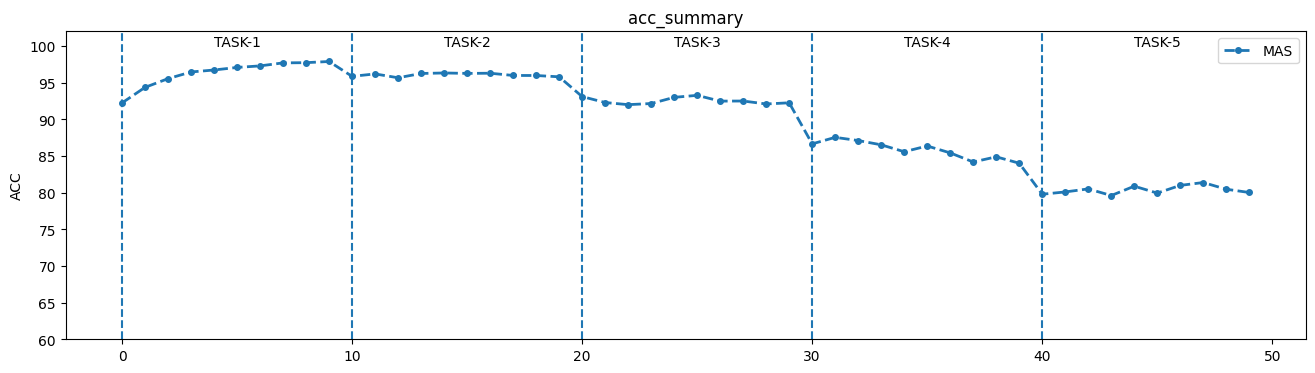

In [19]:
import matplotlib.pyplot as plt


def draw_acc(acc_list, label_list):
    plt.figure(figsize=(16, 4))
    for idx, (acc, label) in enumerate(zip(acc_list, label_list)):
        plt.plot(acc, marker='o', linestyle='--', linewidth=2, markersize=4, label=label)
        
    
    for idx, x in enumerate(range(0, len(acc_list[0]), 10)):
        plt.axvline(x=x, linestyle='--')
        plt.text(x=x+5, y=100, s=f"TASK-{idx+1}", ha='center')
    plt.savefig('acc_summary.png')
    plt.title('acc_summary')
    plt.ylim(60, 102)
    plt.ylabel('ACC')
    plt.legend()
    plt.show() 


acc_list = [mas_acc]
label_list = ['MAS']
# acc_list = [  mas_acc, si_acc, rwalk_acc, scp_acc]
# label_list = [  'MAS', 'SI', 'RWALK', 'SCP']
draw_acc(acc_list, label_list)